# Introduction
This package is designed to perform Bayesian History Matching (BHM) to calibrate a computer model to data. It contains general functions to perform BHM, and specific wrappers to calibrate our lab's model of cardiac growth & remodeling. The goal of this notebook is to provide a tutorial of our BHM software package using a simple example.

In [451]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single-variable BHM
## Generating data
In this example, we will generate some data from a model, and then try to calibrate the model to the data. We will use a simple inverse exponential decay function to generate the data, and then try to calibrate the function to the data. The function is:

In [452]:
import numpy as np
import matplotlib.pyplot as plt

# Inverse Exponential decay function
def exp_decay(t, alpha, beta):
    return alpha * (1 - np.exp(-beta * t))
    # Try rerunning the notebook with a linear function and find the differences
    # return alpha*t + beta

To generate the data, we choose some values for the parameters $a$ and $b$, and then generate some data points using the function.

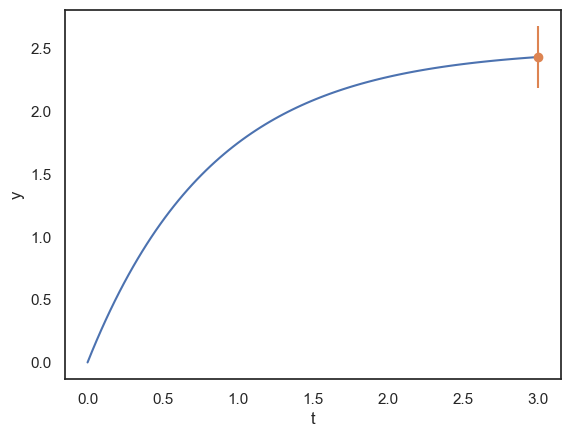

In [453]:
import seaborn as sns

# Generate data
x_target = [2.5, 1.2]
t = np.linspace(0, 3, 100)
y = exp_decay(t, x_target[0], x_target[1])

# Data point to match is the last one, assume a 10% standard deviation
data_mean = y[-1]
data_std = 0.1*data_mean

# Plot function
sns.set_theme(style="white")
plt.plot(t, y)
plt.errorbar(t[-1], data_mean, yerr=data_std, fmt='o')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

## Setting up the Wave class
We first set up a dictionary with the parameters to calibrate. In this case, we have two parameters, $a$ and $b$, and we set the limits of the search space for each parameter.

In [454]:
pars = {'a': {'limits': [0, 5]},
        'b': {'limits': [0, 5]}}

The data is expected in a Pandas dataframe with the mean $\mu$ and standard deviation $\sigma$ in the following Pandas format:

In [455]:
import pandas as pd

# Create dataframe
data = pd.DataFrame(columns=['mu', 'sigma'], index=["y"])
data['mu'] = data_mean
data['sigma'] = data_std
data

,mu,sigma
y,2.431691,0.243169


Bayesian History Matching proceeds in 'waves'. During each wave, we run the model for a set of parameter values, and then discard the parameter values that do not match the data. We then repeat the process with a smaller range of parameter values. We continue this process until we have a small enough range of parameter values that match the data. We then repeat the process with a new set of data points, and continue until we have a set of data points that match the model. We then have a set of parameter values that match the model and the data. We can then use these parameter values to make predictions about the model. 

All functions are contained in the class Wave, which needs to be initialized for each wave. A directory (specified through the second argument, `root_dir`) will be created, we will here name it 'demo' and place it in the current notebook directory. This directory will store all the results of the BHM algorithm. The wave class generates a set of parameter values `x_emu` that are used to train the emulator, and a subset of these parameter values `x_sim` that are used to run the model.

In [456]:
from chameleon.wave import Wave
import pathlib

# Specify export directory
dir_nb = pathlib.Path().absolute()
dir_main = dir_nb / 'demo'

# Initialize wave
wave = Wave(0, dir_main, 3, pars, data, nroy=None, x_target=x_target, n_emu0=2**10, n_emu_min=50)


------
Wave 1
------
Generated emulation point cloud with 1024 points


Initializing the wave resulted in a large set (in this case `n_emu0` = $2^{10}$) of parameter values `x_emu` being generated. A subset of these parameter values `x_sim` (default `n_sim`= $2^{7}$) are then selected using `diversipy` to run the model for emulator training and validation. We can plot the parameter values generated by the emulator, and the parameter values that were run through the model. Note that `n_emu0` and `n_sim` have to be a power of 2 since we use Sobol sequences to generate and sample the parameter values.

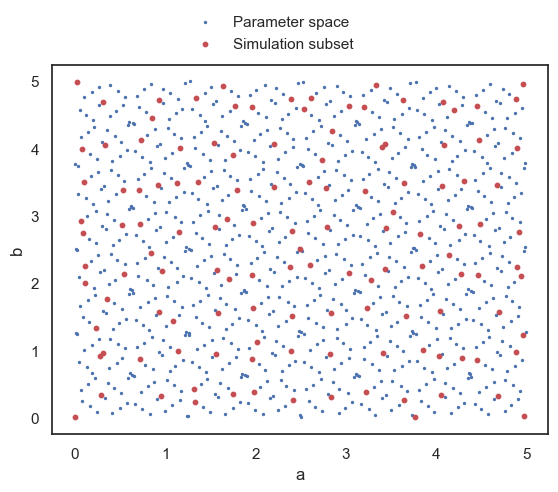

In [457]:
# Plot parameter values
fig, ax = plt.subplots()
plt.scatter(wave.x_emu[:, 0], wave.x_emu[:, 1], s=2)
plt.scatter(wave.x_sim[:, 0], wave.x_sim[:, 1], s=10, c='r')
plt.xlabel('a')
plt.ylabel('b')
plt.legend(['Parameter space', 'Simulation subset'], bbox_to_anchor=(0.25, 1.00), frameon=False)
plt.show()

## Running a single wave
Now that we have set up the Wave class, we can start running our first wave. The wave class does not run the model itself (more on how to include more complex models later), so we need to run the model ourselves using the parameters that were selected in this wave as input, and return the simulated data points to the wave class:

In [458]:
# Run model
y = np.zeros((wave.n_sim, len(t)))
for i in range(wave.n_sim):
    y[i, :] = exp_decay(t, wave.x_sim[i, 0], wave.x_sim[i, 1])

We can then plot the simulated data points, note the large spread in the simulated results, well outside of the error bars of the data point we are trying to match.

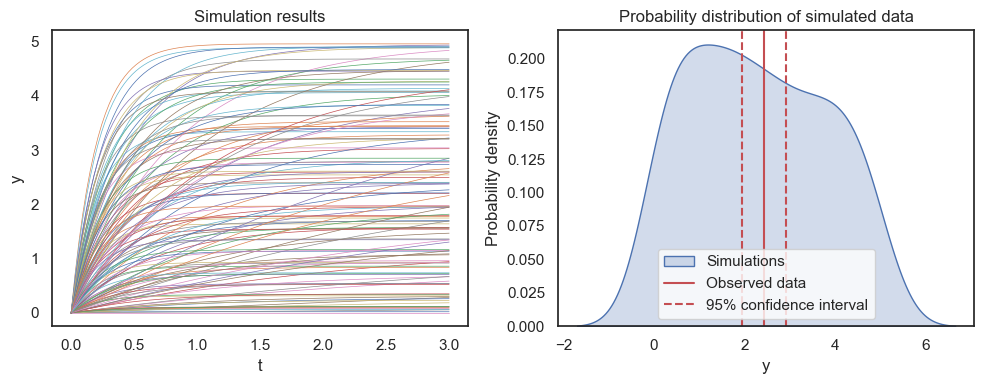

In [459]:
# Data point we are trying to match is the last point
y_sim = y[:, -1]

# Plot simulated data
import seaborn as sns

_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_title('Simulation results')
ax[0].plot(t, y.T, linewidth=0.5)
ax[0].set(xlabel='t', ylabel='y')

# Plot probability distribution of simulated data
ax[1].set_title('Probability distribution of simulated data')
sns.kdeplot(data=y_sim, ax=ax[1], fill=True)
ax[1].axvline(x=wave.y_observed, color='r', linestyle='-')
ax[1].axvline(x=wave.y_observed - 2*wave.sigma_observed, color='r', linestyle='--')
ax[1].axvline(x=wave.y_observed + 2*wave.sigma_observed, color='r', linestyle='--')
ax[1].legend(['Simulations', 'Observed data', '95% confidence interval'])
ax[1].set(xlabel='y', ylabel='Probability density')
plt.tight_layout()
plt.show()

Using the wave class, we will now train Gaussian Process Emulators (GPEs) to emulate the model. 80% of the model results will be used to train the GPEs and the remaining 20% to validate the training quality.

Training GPEs using PyTorch...


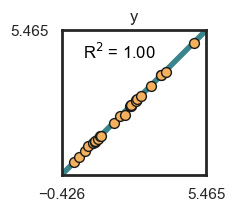

In [460]:
# Add training data to wave
wave.y_sim = y_sim

# Train and validate emulators
wave.gpe_training_validation()

wave.plot_r2(show_fig=True)

We will then use the trained GPEs to predict the simulated data points for all parameters in the NROY region. We then use the implausibility criterion to determine which parameter sets remain in the NROY region. In brief, this metric compares the mean of the emulated and observed data, and divides it by the variance of the emulated and observed data. Thus, the lower this score the *less implausible* a point is to be part of the solution space we are looking for. Here, we discard all parameters sets with an implausibility metric lower than a set threshold, in this case a threshold of wave.threshold=3. Note from the log messages how the NROy region gets reduced. We plot the distribution of values of y that before and after the filtering based on the implausibility criterion.

Emulating 1024 points...
Emulation completed in 0.01 seconds
326 points remaining in NROY region after implausibility check
y is the most implausible output (100.0% of all points)


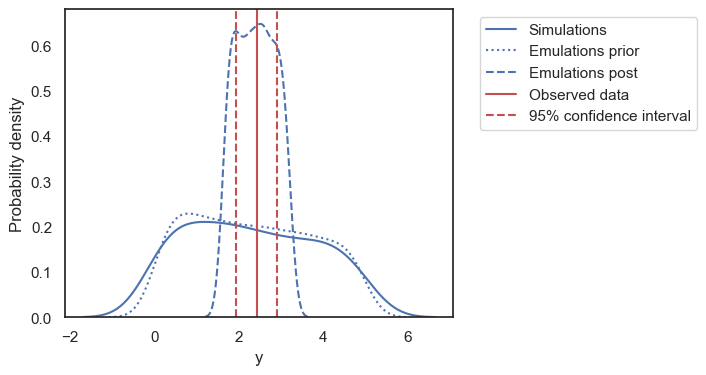

In [461]:
# Predict data for all parameter values
wave.gpe_emulate()

# Calculate implausibility and find non-implausible parameter values
wave.find_nroy()

# Plot probability distribution of simulated data
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(5, 4))
sns.kdeplot(data=wave.y_sim, ax=ax)
sns.kdeplot(data=wave.y_emu, ax=ax, linestyle=':')
sns.kdeplot(data=wave.nroy_y, ax=ax, linestyle='--')

ax.axvline(x=wave.y_observed, color='r', linestyle='-')
ax.axvline(x=wave.y_observed - 2*wave.sigma_observed, color='r', linestyle='--')
ax.axvline(x=wave.y_observed + 2*wave.sigma_observed, color='r', linestyle='--')

ax.legend(['Simulations', 'Emulations prior', 'Emulations post', 'Observed data', '95% confidence interval'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(xlabel='y', ylabel='Probability density')
plt.show()

## Running a full BHM scheme
As decribed earlier, Bayesian History Matching proceeds in 'waves'. During each wave, we run the model for a set of parameter values, and then discard the parameter values that do not match the data. We then repeat the process with a smaller range of parameter values. We continue this process until we have a small enough range of parameter values that match the data. We then repeat the process with a new set of data points, and continue until we have a set of data points that match the model. We then have a set of parameter values that match the model and the data. We can then use these parameter values to make predictions about the model.

The following code will run a full BHM scheme for our example. Note from the log messages how the parameter space is reduced with each wave. We also use a wrapper function *flood* to call all the functions used in the single wave (training/validation, prediction using GPEs, and selection of the new NROY region) above for a shorter code.

In [462]:
import shutil

# Specify export directory
dir_main = dir_nb / 'demo'

# Remove directory if it already exists
if dir_main.exists():
    shutil.rmtree(dir_main)

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)

    # Initialize wave    
    wave = Wave(i_wave, dir_main, wave_threshold, pars, data, nroy=nroy,
            clear_log=(i_wave == 0), n_emu0=2**15, n_emu_min=100, x_target=x_target)

    # Run simulations for all parameter sets in current wave set x
    y = np.zeros((wave.n_sim, len(t)))
    for i in range(wave.n_sim):
        y[i, :] = exp_decay(t, wave.x_sim[i, 0], wave.x_sim[i, 1])
    wave.y_sim = y[:, -1]

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    wave.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = wave.is_flooded(i_wave, min_waves=4, max_waves=6)
    nroy = wave.nroy
    i_wave += 1

-----------
Parameters:
-----------
- a: [0.0 - 5.0]
- b: [0.0 - 5.0]


-------------
Observations:
-------------
- y: 2.4316906938817686 ± 0.24316906938817687


-------------
Constants:
-------------
None specified


------
Wave 1
------
Generated emulation point cloud with 32768 points
Training GPEs using PyTorch...
Emulating 32768 points...
Emulation completed in 0.04 seconds
17399 points remaining in NROY region after implausibility check
y is the most implausible output (100.0% of all points)
NROY size change at Wave 1 is -0.47: no convergence

------
Wave 2
------
Training GPEs using PyTorch...
Emulating 17399 points...
Emulation completed in 0.01 seconds
13117 points remaining in NROY region after implausibility check
y is the most implausible output (100.0% of all points)
NROY size change at Wave 2 is -0.25: no convergence

------
Wave 3
------
Training GPEs using PyTorch...
Emulating 13117 points...
Emulation completed in 0.01 seconds
9771 points remaining in NROY region after

## Analyzing the results
With our first BHM scheme completed, we can now analyze the results. All output results and some figures are already stored in the directory wave.dir (in this case the subdirectory "demo" from where this notebook is stored on your local system. First, it is important to always check if the emulators were trained correctly.

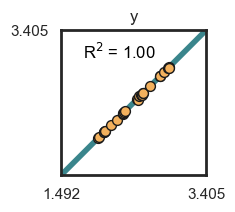

In [463]:
wave.plot_r2(show_fig=True, save_fig=False)

 With the emulator quality confirmed, we can run the model for the parameter values in the final NROY region, and plot the results. Note how the simulated data points are now within the error bars of the observed data point.

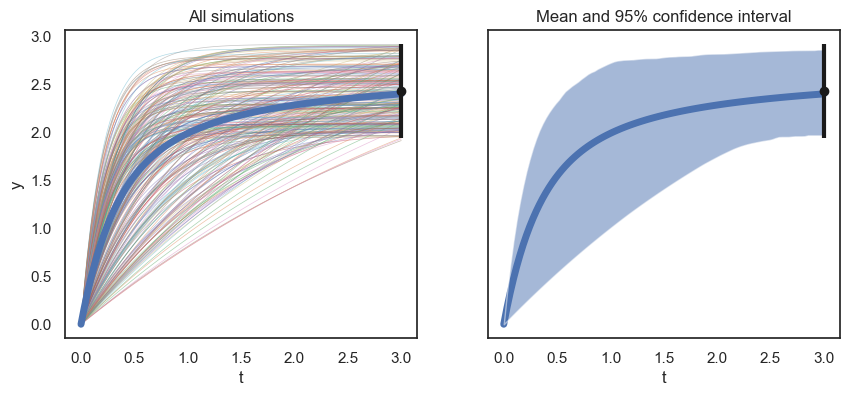

In [464]:
# Run simulations for all parameter sets in final NROY region
y = np.zeros((wave.n_posterior, len(t)))
for i in range(wave.n_posterior):
    y[i, :] = exp_decay(t, wave.x_posterior[i, 0], wave.x_posterior[i, 1])
wave.y_posterior = y
wave.pickle_wave()

def plot_posterior(data_t, data_mean, data_std, t, y):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
    
    # All simulations
    ax[0].set_title('All simulations')
    ax[0].plot(t, y.mean(axis=0), linewidth=5, zorder=1)
    ax[0].plot(t, y.T, linewidth=0.5, zorder=0, alpha=0.5)
    ax[0].errorbar(data_t, data_mean, yerr=2*data_std, fmt='o', linewidth=3, color="k")
    ax[0].set(xlabel='t', ylabel='y')
    
    # Mean and 95% confidence interval
    ax[1].set_title('Mean and 95% confidence interval')
    ax[1].plot(t, y.mean(axis=0), linewidth=5, zorder=1)
    ax[1].fill_between(t, np.percentile(y, 2.5, axis=0), np.percentile(y, 95.0, axis=0), alpha=0.5)
    ax[1].errorbar(data_t, data_mean, yerr=2*data_std, fmt='o', linewidth=3, color="k")
    ax[1].set(xlabel='t')
    
    plt.show()
    
plot_posterior(t[-1], data_mean, data_std, t, y)

This package also includes a class called Camouflage that contains a comprehensive set of plotting functions to analyze the BHM results. We can for example plot the evolution of the simulated versus the observed data points over the course of the BHM scheme. Note how the simulated data points move closer to the observed data point as the BHM scheme progresses and are within the 95% confidence interval of the observed data point after 4 waves.

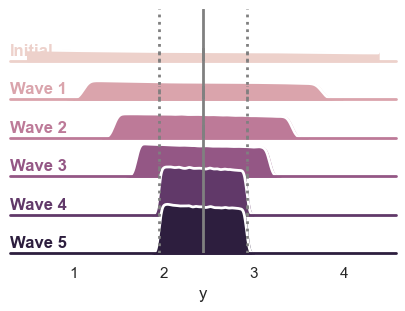

In [465]:
from chameleon.colors import Camouflage

# Initialize Camouflage class
camo = Camouflage(dir_main)

# Plot wave progression
camo.plot_waves_y(show_fig=True)

Similarly, we can plot the evolution of the parameter values over the course of the BHM scheme.

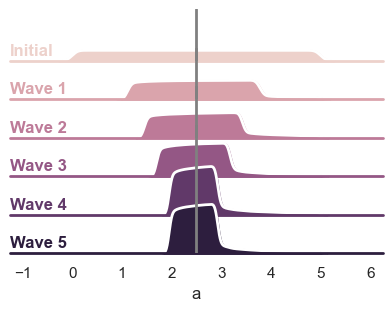

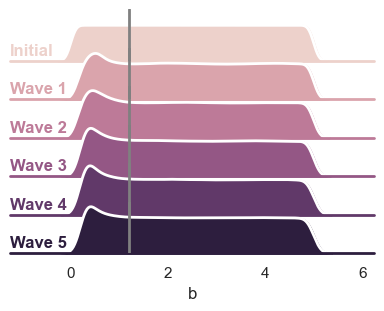

In [466]:
camo.plot_waves_x(show_fig=True)

Note how the parameter values for *a* moved closer to the true parameter values as the BHM scheme progresses, but *b* barely changed. This is due to the latter parameter being more influential on the shape and not the final value. To address this, we can take multiple data outputs from our model, and match each output separately. We will do this in the next section.

# Multi-output BHM
## Generating data
We will now generate three instead of one data point using the same function, but by taking data at diffeent time points.

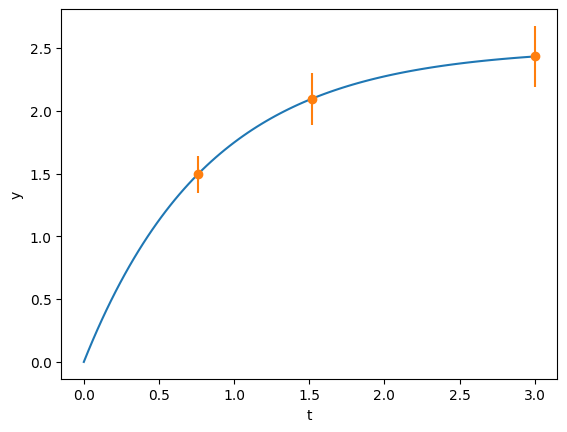

,mu,sigma
y1,1.492774,0.149277
y2,2.094198,0.209420
y3,2.431691,0.243169


In [467]:
# Generate data
y = exp_decay(t, x_target[0], x_target[1])

i_sample = [int(len(t)/4), int(len(t)/2), -1]
data_mean = y[i_sample]
data_std = 0.1*data_mean
data_names = ['y1', 'y2', 'y3']

# Plot function
plt.plot(t, y)
plt.errorbar(t[i_sample], data_mean, yerr=data_std, fmt='o')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

# Create dataframe
data = pd.DataFrame(columns=['mu', 'sigma'], index=data_names)
data['mu'] = data_mean
data['sigma'] = data_std
data

## Running BHM
We can now set up the BHM scheme as before, but now with three data points instead of one. Every data point will be emulated by a separate GPE, and the implausibility metric will be calculated for each data point separately. The final implausibility metric will be the maximum of the three implausibility metrics, to consider a worst-case scenario.

In [468]:
# Specify export directory
dir_main = dir_nb / "bhm_demo"

# Remove directory if it already exists
if dir_main.exists():
    import shutil
    shutil.rmtree(dir_main)

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)

    # Initialize wave    
    wave = Wave(i_wave, dir_main, wave_threshold, pars, data, nroy=nroy,
            clear_log=(i_wave == 0), n_emu0=2**15, n_emu_min=1000, x_target=x_target)

    # Run simulations for all parameter sets in current wave set x
    y = np.zeros((wave.n_sim, len(t)))
    for i in range(wave.n_sim):
        y[i, :] = exp_decay(t, wave.x_sim[i, 0], wave.x_sim[i, 1])
    wave.y_sim = y[:, i_sample]

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    wave.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = wave.is_flooded(i_wave, min_waves=5, max_waves=10)
    nroy = wave.nroy
    i_wave += 1

-----------
Parameters:
-----------
- a: [0.0 - 5.0]
- b: [0.0 - 5.0]


-------------
Observations:
-------------
- y1: 1.4927741961771672 ± 0.14927741961771673
- y2: 2.0941984720453797 ± 0.209419847204538
- y3: 2.4316906938817686 ± 0.24316906938817687


-------------
Constants:
-------------
None specified


------
Wave 1
------
Generated emulation point cloud with 32768 points
Training GPEs using PyTorch...
Emulating 32768 points...
Emulation completed in 0.08 seconds
10991 points remaining in NROY region after implausibility check
y1 is the most implausible output (57.42% of all points)
NROY size change at Wave 1 is -0.66: no convergence

------
Wave 2
------
Training GPEs using PyTorch...
Emulating 10991 points...
Emulation completed in 0.03 seconds
7056 points remaining in NROY region after implausibility check
y3 is the most implausible output (51.45% of all points)
NROY size change at Wave 2 is -0.36: no convergence

------
Wave 3
------
Training GPEs using PyTorch...
Emulating 

## Analyzing the results
First, run posterior simulations for the final NROY region, which is a subset of `n_posterior` parameter sets that are in the NROY region of the final wave. We save the posterior results to the wave class and export it for more plotting (next). Plot the results using the function we defined earlier:

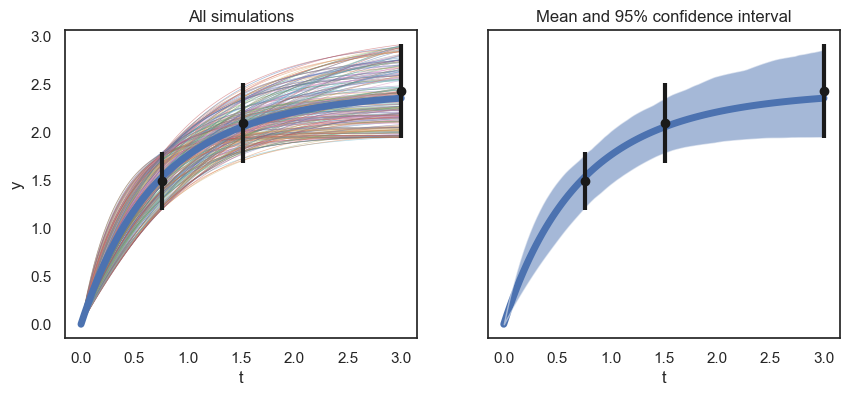

In [469]:
# Run simulations for all parameter sets in final NROY region
y = np.zeros((wave.n_posterior, len(t)))
for i in range(wave.n_posterior):
    y[i, :] = exp_decay(t, wave.x_posterior[i, 0], wave.x_posterior[i, 1])

# Store posterior
wave.y_posterior = y[:, i_sample]
wave.pickle_wave()

# Plot posterior simulations
plot_posterior(t[i_sample], data_mean, data_std, t, y)

Use the Camouflage class to plot the posterior distributions of the simulated data points. It will generate a box and violin version, we here show the box plot version.

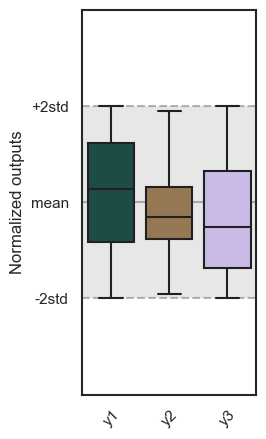

In [470]:
# Initialize camouflage class
camo = Camouflage(dir_main)

# Plot posterior distributions
camo.plot_nroy_data(show_box=True)

We can use the Camouflage class to plot the evolution of the NROY over the course of the BHM scheme. Note how the NROY shrinks with each wave.

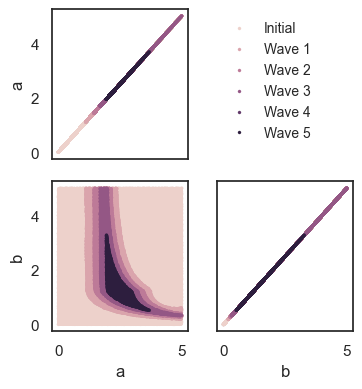

In [471]:
camo.plot_nroy_waves(show_fig=True, tile_size=2)

Now plot the evolution of the NROY for each parameter and output

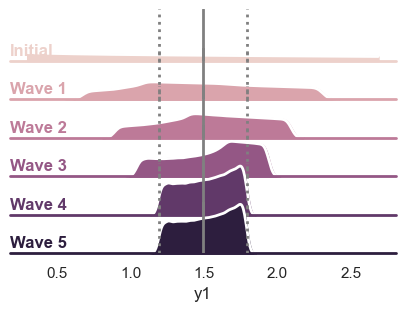

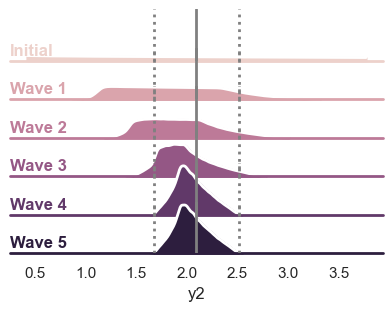

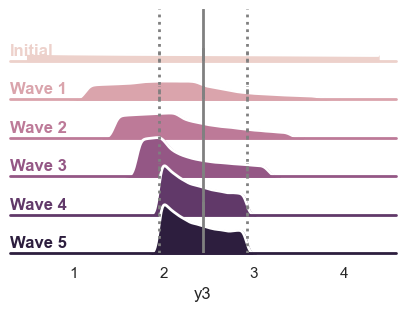

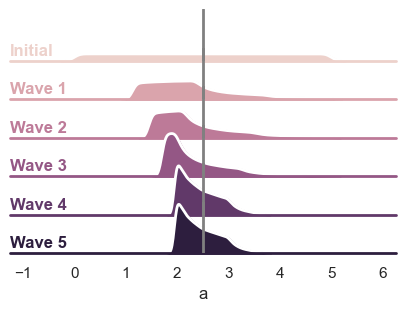

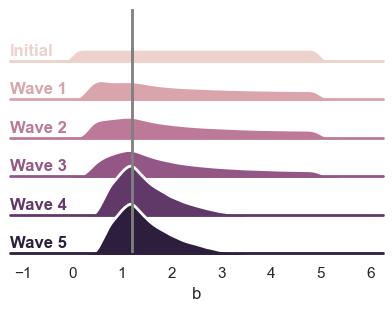

In [472]:
# Plot wave progression
camo.plot_waves_y(show_fig=True)
camo.plot_waves_x(show_fig=True)

Some more plots: the multidimensional input and output spaces, and the evolution of the implausibility metric over the course of the BHM scheme. This may not be the most useful for this simple example, but can be useful for more complex models.

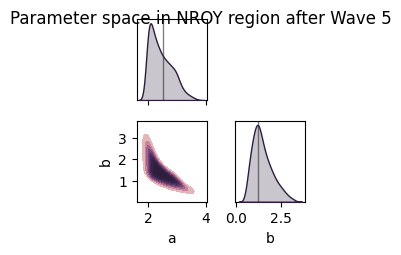

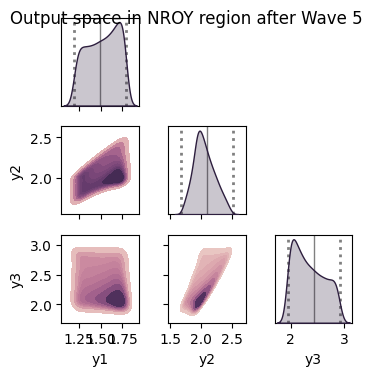

In [473]:
camo.plot_nroy_x(show_fig=True)
camo.plot_nroy_y(show_fig=True)

# Global sensitivity analysis
This package include a global sensitivity analysis based on the SALib package, using the Sobol method. In most models, performing a global sensitivity analysis is computationally expensive, so here we take advantage of the low computational cost of the emulators to perform the analysis. The following code is an example of how to run the analysis. Similar to a BHM wave, we need to run our our own model with the parameter sets given by the Saltelli method. The sensitivity analysis will be performed on the specified parameter space.

In [474]:
dir_sense = dir_nb / 'demo' / 'sensitivity'

# Setting up the wave class
wave = Wave(0, dir_sense, 5.0, pars, data, nroy=nroy,
            clear_log=True, n_emu0=2**11, n_emu_min=2**11, x_target=x_target)

# Run simulations for all parameter sets in current wave set x
y = np.zeros((wave.n_sim, len(t)))
for i in range(wave.n_sim):
    y[i, :] = exp_decay(t, wave.x_sim[i, 0], wave.x_sim[i, 1])
wave.y_sim = y[:, i_sample]

# Wrapper to run gpe_training_validation and sobol_sensitivity
wave.surf_sensitivity()

-----------
Parameters:
-----------
- a: [0.0 - 5.0]
- b: [0.0 - 5.0]


-------------
Observations:
-------------
- y1: 1.4927741961771672 ± 0.14927741961771673
- y2: 2.0941984720453797 ± 0.209419847204538
- y3: 2.4316906938817686 ± 0.24316906938817687


-------------
Constants:
-------------
None specified


------
Wave 1
------
Regenerating emulation cloud from 1445 to 2048 points...
Training GPEs using PyTorch...
Performing sensitivity analysis...
Emulating 2048 points...
Emulation completed in 0.66 seconds


/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


The results of the sensitivity analysis are stored in the Wave class and are pickcled to wave.dir. We can plot the results using the Camouflage class. First, we can plot the importance of each parameter on each output, in circle or matrix format, and the total importance of each parameter on the entire parameter space.

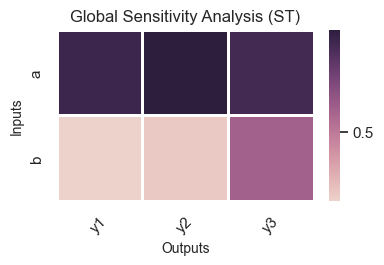

In [475]:
# Run sensitivity analysis
camo = Camouflage(dir_sense)

camo.plot_sensitivity_matrix(show_fig=True, tile_size=2)

From these figures, it is clear that parameter *a* is more important than parameter *b* in determining the final value of the function. *y1* *y2* are more sensitive to to *b* than *y3*. This is in line with the function we were testing, where parameter *b* is more important in determining the shape of the function and *a* the final value. We can also analyze interactions between parameters and outputs. This plot is not very interesting for this simple analysis, but can be useful for more complex models:

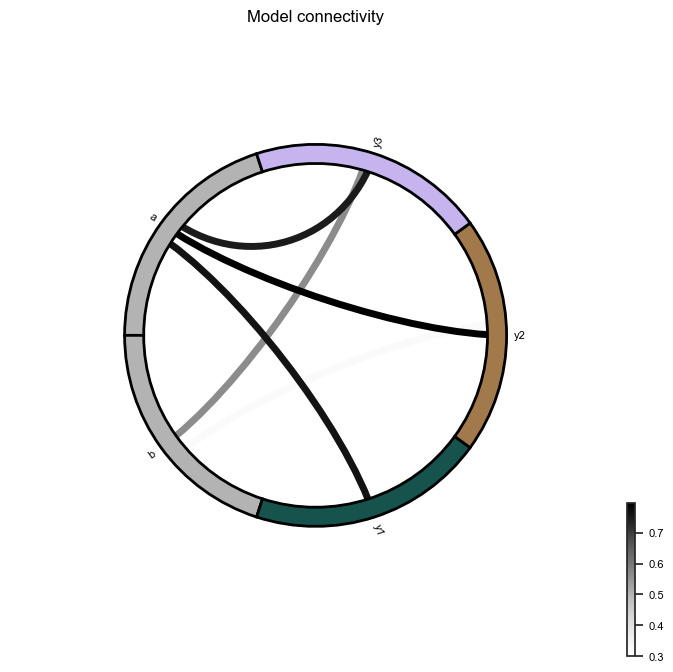

In [476]:
camo.plot_connectivity(show_fig=True)